<a href="https://colab.research.google.com/github/snehahs03/medical-image-analysis/blob/main/inception_2_conf_final28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [15]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
%cd /content/drive/MyDrive/medical-image-analysis

/content/drive/MyDrive/medical-image-analysis


In [6]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications.densenet import DenseNet201
%matplotlib inline
import matplotlib.pyplot as plt

import json
import math
import cv2
from PIL import Image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import Sequential
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools

In [7]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG


eczema_test = np.array(Dataset_loader("/content/drive/MyDrive/medical-image-analysis/test/Eczema Photos",224))
melonoma_test = np.array(Dataset_loader("/content/drive/MyDrive/medical-image-analysis/test/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_test = np.array(Dataset_loader("/content/drive/MyDrive/medical-image-analysis/test/Psoriasis pictures Lichen Planus and related diseases", 224))


eczema_test_label = np.full(len(eczema_test),0)
melonoma_test_label = np.full(len(melonoma_test),1)
psoriasis_test_label = np.full(len(psoriasis_test),2)



X_test = np.concatenate((eczema_test, melonoma_test, psoriasis_test), axis=0)
Y_test = np.concatenate((eczema_test_label, melonoma_test_label, psoriasis_test_label), axis = 0)






100%|██████████| 352/352 [00:05<00:00, 63.13it/s] 


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
model2 = keras.models.load_model('inception_model2.h5')

In [9]:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]
Y_test = to_categorical(Y_test, num_classes= 3)
loss_test, acc_test = model2.evaluate(X_test, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

31/31 [==============================] - 14s 98ms/step - loss: 0.3990 - acc: 0.8722
Test: accuracy = 0.872188  ;  loss = 0.399021


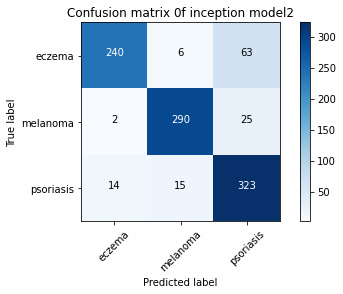

In [10]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix 0f inception model2',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model2.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
classes = ['eczema', 'melanoma', 'psoriasis']
plot_confusion_matrix(confusion_mtx, classes)

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       309
           1       0.93      0.91      0.92       317
           2       0.79      0.92      0.85       352

    accuracy                           0.87       978
   macro avg       0.89      0.87      0.87       978
weighted avg       0.88      0.87      0.87       978



In [12]:
img_size = 160
batch_holder = np.zeros((9, img_size, img_size, 3))
img_dir = '/content/drive/MyDrive/medical-image-analysis/medical-image-analysis/images'
for i, img in enumerate(os.listdir(img_dir)):
  img  = image.load_img(os.path.join(img_dir,img), target_size=(img_size, img_size))
  batch_holder[i, :] =img

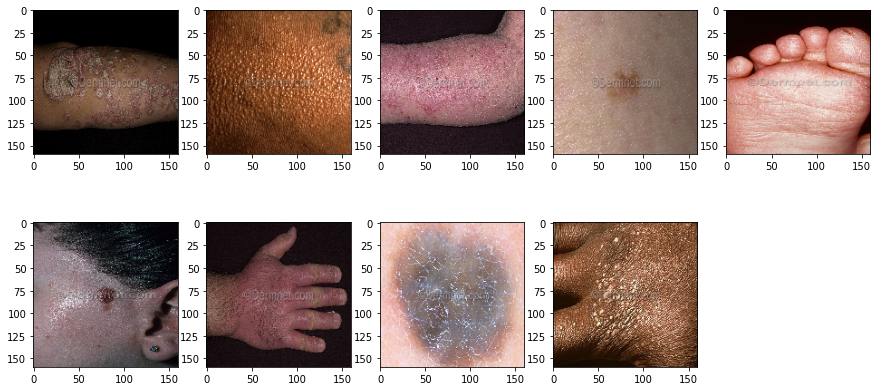

In [14]:
result = np.argmax(batch_holder)
fig = plt.figure(figsize=(15,15))
for i, img in enumerate(batch_holder):
  fig.add_subplot(4,5,i+1)
    plt.title(get_label_name(result[i][0]))
  plt.imshow(img/256.)
plt.show()